<a href="https://colab.research.google.com/github/duongnghiephuy/Student-Project/blob/master/Using_pretrained_conv_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.applications import vgg16


The imagenet convolutional base is used while the top Dense layers are discared by include_top=False.

The structure of that convolutional base is below:

In [0]:
conv_base=vgg16.VGG16(weights="imagenet",input_shape=(150,150,3),include_top=False)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_dir="/content/gdrive/My Drive/Practice/data/small_data/train"
validation_dir="/content/gdrive/My Drive/Practice/data/small_data/validation"
test_dir="/content/gdrive/My Drive/Practice/data/small_data/test"



**There are several ways to take advantage of that pretrained convolutional base:**
- Run the data through convolutional base and feed the output to the Dense Layer 
- Connect the convolutional base to customized Dense Layers on top to form a model.
That model then is trained while:
             +  Freezing all learned parameters in convolutional base
             +  Freezing only a few bottom layers of convolutional base
Regardless of the methods, the bottom layers should be frozen before training. Otherwise, the learned parameters would vanish.
                        

**1. Run the data through convolutional base**

This is the least expensive method.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
datagen=ImageDataGenerator(rescale=1.0/255)
batch_size=20
def extraction(directory,num_samples):
  generator=datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode="binary")
  features=np.zeros(shape=(num_samples,4,4,512))
  labels=np.zeros(shape=(num_samples))
  i=0
  for batch_inputs,batch_labels in generator:
    features[batch_size*i:batch_size*(i+1)]=conv_base.predict(batch_inputs)
    labels[batch_size*i:batch_size*(i+1)]=batch_labels
    i+=1
    if i*batch_size>=num_samples:
      break
    return features,labels
  
train_features,train_labels=extraction(train_dir,2000)
train_features=np.reshape(train_features,(2000,4*4*512))
val_features,val_labels=extraction(validation_dir,1000)
val_features=np.reshape(val_features,(1000,4*4*512))
test_features,test_labels=extraction(test_dir,1000)
test_features=np.reshape(test_features,(1000,4*4*512))


    
    
  
  
  
  
  

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


We then feed the output of convolutional base to feedforward network.

In [0]:
from  keras import models, layers
from keras import optimizers

network=models.Sequential()
network.add(layers.Dense(512,input_dim=4*4*512,activation="relu"))
network.add(layers.Dropout(0.4))
network.add(layers.Dense(1,activation="sigmoid"))

network.compile(loss="binary_crossentropy",optimizer=optimizers.RMSprop(lr=0.0001),metrics=["acc"])

history=network.fit(train_features,train_labels,epochs=10,batch_size=32,validation_data=(val_features,val_labels))



Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6818 - acc: 0.9975 - val_loss: 0.6956 - val_acc: 0.9880
Epoch 2/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6417 - acc: 0.9980 - val_loss: 0.6550 - val_acc: 0.9880
Epoch 3/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5995 - acc: 0.9990 - val_loss: 0.5834 - val_acc: 0.9930
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5524 - acc: 0.9990 - val_loss: 0.5498 - val_acc: 0.9890
Epoch 5/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5025 - acc: 1.0000 - val_loss: 0.5256 - val_acc: 0.9880
Epoch 6/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4508 - acc: 1.0000 - val_loss: 0.4738 - val_acc: 0.9890
Epoch 7/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3991 - acc: 1.0000 - val_loss: 0.4506 - val_acc: 0.9880
Epoch 8/10
2

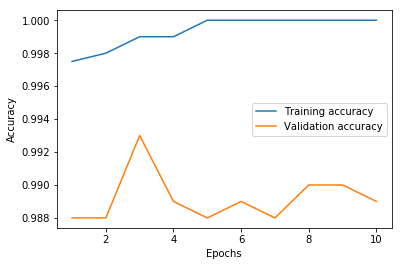

In [0]:
import matplotlib.pyplot as plt
acc=history.history["acc"]
val_acc=history.history["val_acc"]
plt.plot(range(1,len(acc)+1),acc,label="Training accuracy")
plt.plot(range(1,len(acc)+1),val_acc,label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()




**The accuracy in training set reaches 100% while that in validation set reaches 99%.**

It easily surpasses the naive and small convolutional network that we trained ourselves.

This inexpensive method proves to be cost effective.

**2. Connect the convolutional base to Dense Layers. Train the model while freezing the convolutional base**

In [0]:
from  keras import models, layers

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()







Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
conv_base.trainable=False
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
traingen=ImageDataGenerator(rotation_range=40,height_shift_range=0.2,width_shift_range=0.2,rescale=1.0/255,horizontal_flip=True,shear_range=0.1,fill_mode="nearest")
valgen=ImageDataGenerator(rescale=1.0/255)
traingenerator=traingen.flow_from_directory(train_dir,target_size=(150,150),class_mode="binary",batch_size=32)
valgenerator=valgen.flow_from_directory(validation_dir,target_size=(150,150),class_mode="binary",batch_size=20)

model.compile(loss="binary_crossentropy",optimizer=optimizers.RMSprop(lr=0.0001),metrics=["acc"])
history=model.fit_generator(traingenerator,steps_per_epoch=100,epochs=8,validation_data=valgenerator,validation_steps=50,use_multiprocessing=True)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/8
100/100 [==============================] - 1051s 11s/step - loss: 0.4931 - acc: 0.7531 - val_loss: 0.2986 - val_acc: 0.8760
Epoch 2/8
100/100 [==============================] - 1013s 10s/step - loss: 0.3862 - acc: 0.8222 - val_loss: 0.2693 - val_acc: 0.8910
Epoch 3/8
100/100 [==============================] - 1007s 10s/step - loss: 0.3616 - acc: 0.8400 - val_loss: 0.2547 - val_acc: 0.8910
Epoch 4/8
100/100 [==============================] - 1016s 10s/step - loss: 0.3339 - acc: 0.8500 - val_loss: 0.2503 - val_acc: 0.8910
Epoch 5/8
100/100 [==============================] - 1011s 10s/step - loss: 0.3296 - acc: 0.8597 - val_loss: 0.3171 - val_acc: 0.8640
Epoch 6/8
100/100 [==============================] - 1019s 10s/step - loss: 0.2994 - acc: 0.8681 - val_loss: 0.2447 - val_acc: 0.9000
Epoch 7/8
100/100 [==============================] - 1011s 10s/step - loss: 0.2894 - acc: 0.8694 - val_loss: 0.2

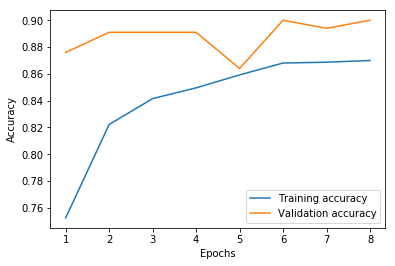

In [0]:

acc=history.history["acc"]
val_acc=history.history["val_acc"]
plt.plot(range(1,len(acc)+1),acc,label="Training accuracy")
plt.plot(range(1,len(acc)+1),val_acc,label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In this particular case, the accuracy of this second method coverges more slowly that the first method. That is because the cats, dogs images dominates the imagenet so its convolutional base has already reached a high accuracy when distinguish dogs and cats.